# Neural nets for BO


Source: https://gdmarmerola.github.io//ts-for-bayesian-optim/

In [1]:
import jax
import numpy as np
import seaborn as sns
import flax.linen as nn
import jax.numpy as jnp
import matplotlib.pyplot as plt

from rebayes_mini.methods import gauss_filter
from rebayes_mini.methods import base_filter

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
sns.set_palette("colorblind")

In [4]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["figure.figsize"] = (7.2, 4.2)

In [5]:
jnp.set_printoptions(suppress=True, precision=5, linewidth=200)

In [6]:
def ackley_1d(x, y=0):
    out = (-20*jnp.exp(-0.2*jnp.sqrt(0.5*(x**2 + y**2))) 
           - jnp.exp(0.5*(jnp.cos(2*jnp.pi*x) + jnp.cos(2*jnp.pi*y)))
           + jnp.e + 20)
    
    # returning
    return out

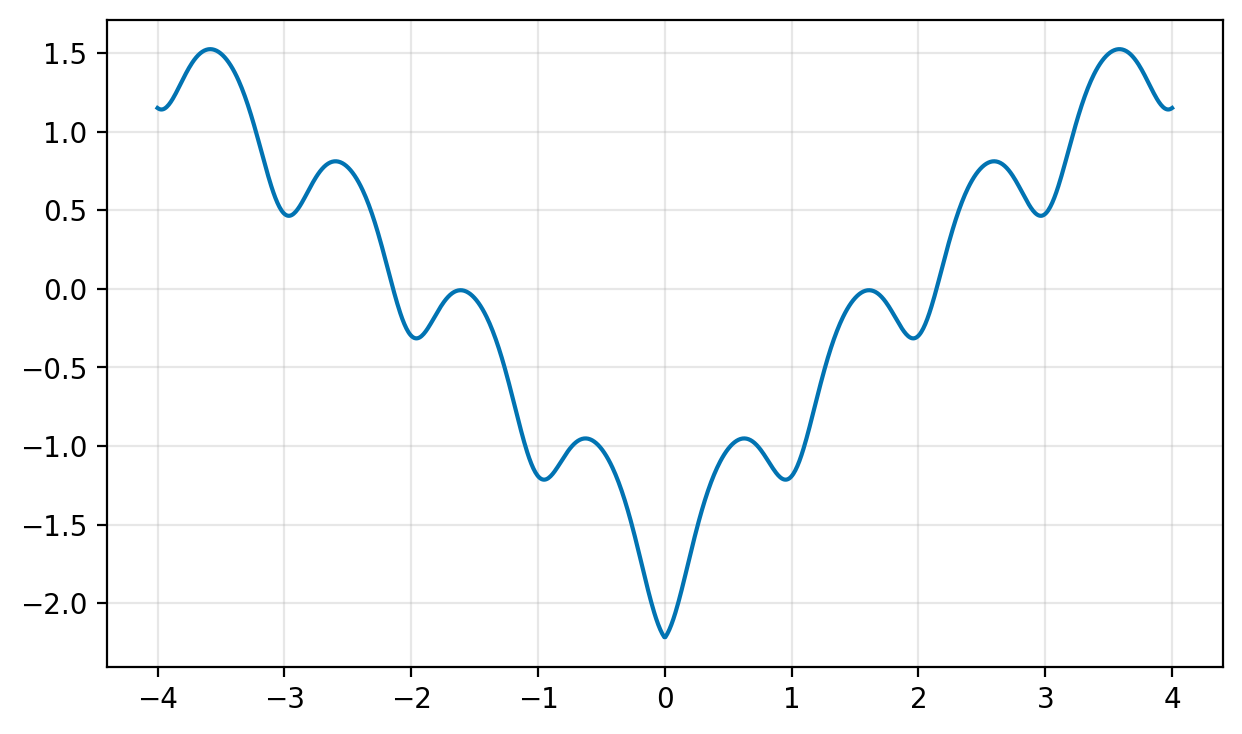

In [7]:
xrange = jnp.linspace(-4, 4, 1000)
yvals = ackley_1d(xrange)
ymean = yvals.mean()
ystd = yvals.std()
yvals = (yvals - ymean) / ystd

plt.plot(xrange, yvals)
plt.grid(alpha=0.3)

## The BNN surrogate model

In [8]:
class MLP(nn.Module):
    n_hidden: int = 20

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(self.n_hidden)(x)
        x = jnp.sin(x)
        x = nn.Dense(self.n_hidden)(x)
        x = nn.elu(x)
        x = nn.Dense(self.n_hidden)(x)
        x = nn.elu(x)
        x = nn.Dense(1, name="last_layer")(x)
        return x

In [9]:
key = jax.random.PRNGKey(31415)
key_data, key_train, key_sample = jax.random.split(key, 3)

## Training model

In [10]:
x_samples = jax.random.uniform(key_data, shape=(15,1), minval=-4, maxval=4)

In [11]:
y_samples = ackley_1d(x_samples)
y_samples = (y_samples - ymean) / ystd

In [13]:
def callback(bel_update, bel_pred, y, x, agent):
    Ht = agent.grad_mean(bel_update.mean, x)
    yhat = agent.mean_fn(bel_update.mean, x).astype(float)
    err = y - yhat - Ht @ (bel_pred.mean - bel_update.mean)
    return jnp.abs(err)

In [14]:
%%time
model = MLP()
params_init = model.init(key_train, x_samples)

def cov_fn(y): return 1e-9
agent = base_filter.SquareRootFilter(model.apply, cov_fn, dynamics_covariance=0.0, n_inner=10)
bel_init = agent.init_bel(params_init, cov=0.1)

# replacing last-layer covariance
bel_init = bel_init.replace(W=bel_init.W.at[-21:, -21:].set(jnp.eye(21) * 5.0))

bel, hist = agent.scan(bel_init, y_samples, x_samples, callback)
hist = jax.tree.map(np.array, hist)
bel = jax.block_until_ready(bel)

CPU times: user 22.6 s, sys: 438 ms, total: 23 s
Wall time: 6.27 s


In [15]:
hist.squeeze()

array([0.34573, 1.11117, 3.07133, 0.75054, 0.15381, 0.0398 , 4.22076, 0.69999, 0.04604, 0.36834, 0.09637, 0.01978, 2.33605, 0.06874, 1.31622], dtype=float32)

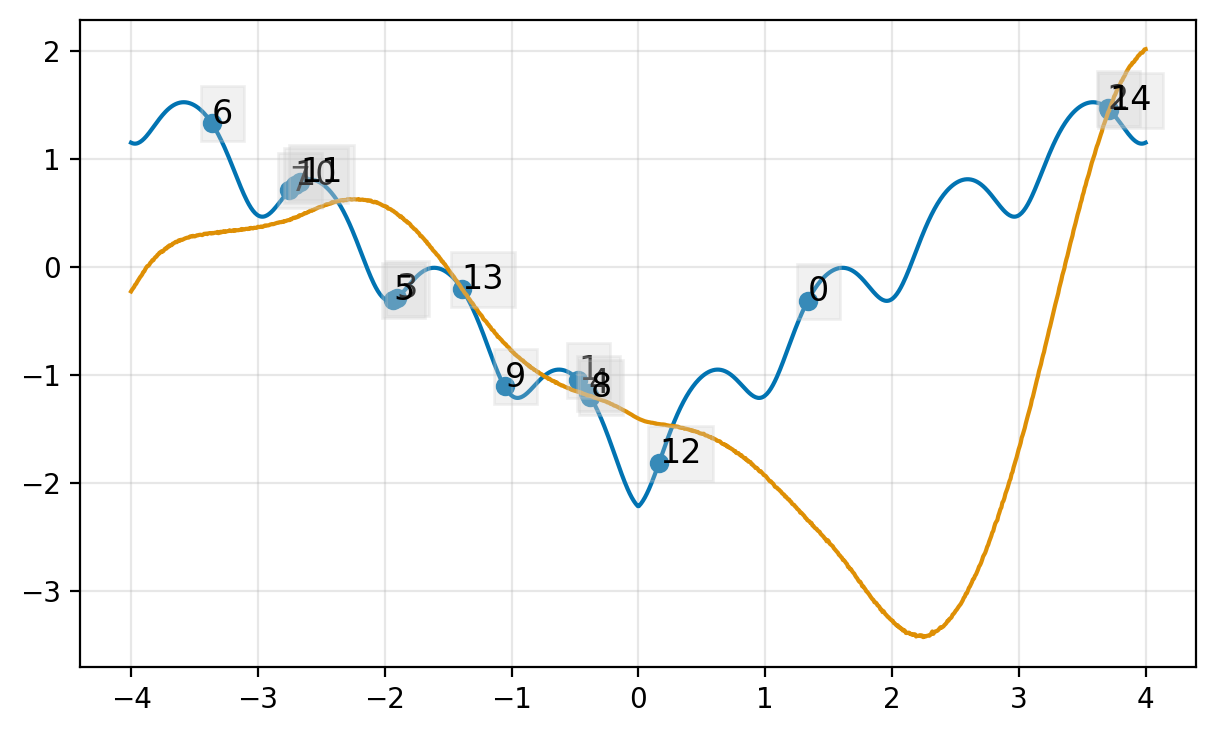

In [16]:
plt.scatter(x_samples, y_samples)

for i, (x, y) in enumerate(zip(x_samples, y_samples)):
    plt.text(x.item(), y.item(), i, fontsize=12, backgroundcolor="#ccc4")

plt.plot(xrange, yvals)
plt.grid(alpha=0.3)
plt.plot(xrange, agent.mean_fn(bel.mean, xrange[:, None]))

## Copy

In [17]:
jax.tree.map(jnp.shape, params_init)

{'params': {'Dense_0': {'bias': (20,), 'kernel': (1, 20)},
  'Dense_1': {'bias': (20,), 'kernel': (20, 20)},
  'Dense_2': {'bias': (20,), 'kernel': (20, 20)},
  'last_layer': {'bias': (1,), 'kernel': (20, 1)}}}

In [18]:
eps = jax.random.normal(key_sample, (100, len(bel.mean)))

In [19]:
sample_params = jnp.einsum("ji,sj->si", bel.W, eps) + bel.mean

In [20]:
eval_samples = jax.vmap(agent.mean_fn, in_axes=(0, None))(sample_params, xrange[:, None]).squeeze()

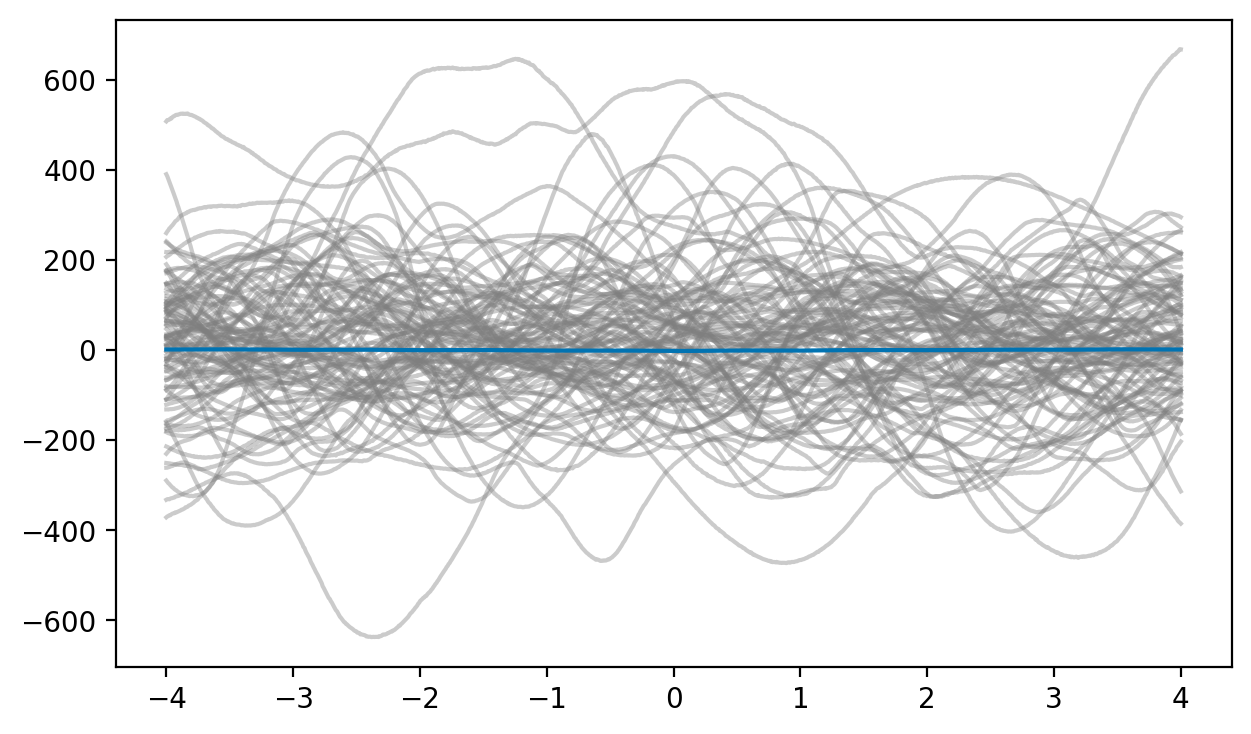

In [21]:
plt.plot(xrange, eval_samples.T, c="tab:gray", alpha=0.4)
plt.plot(xrange, yvals)

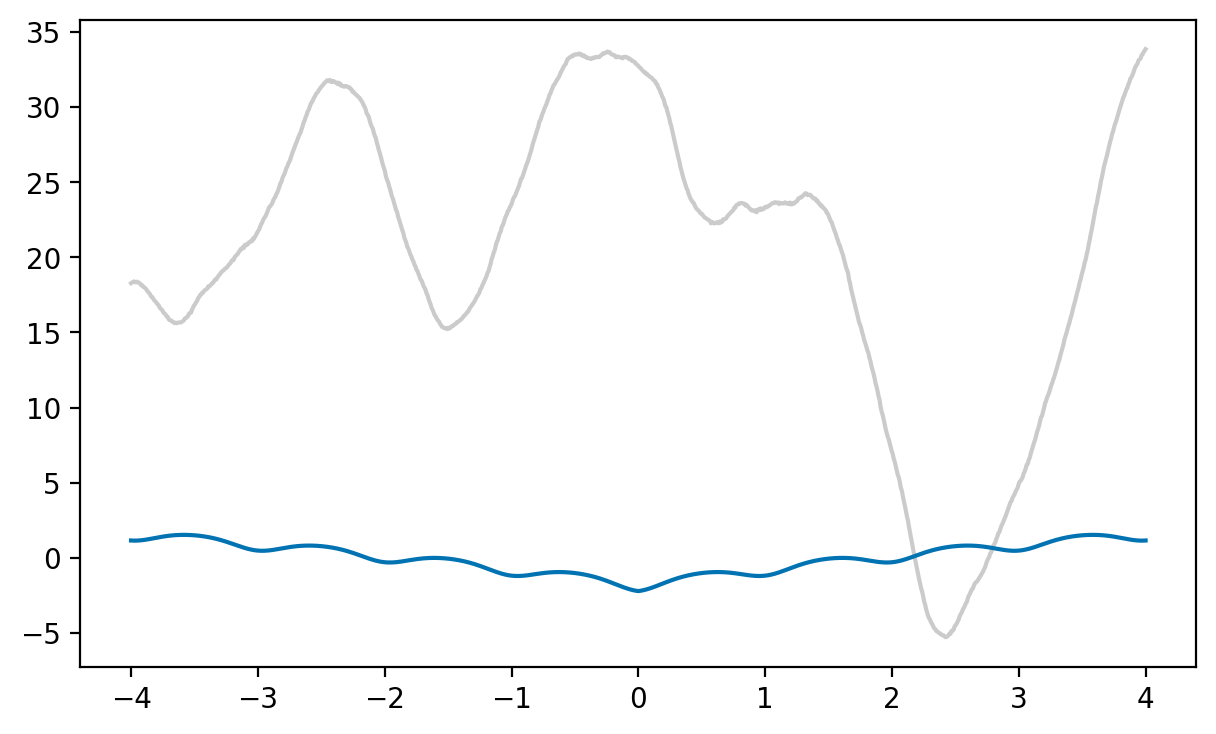

In [22]:
plt.plot(xrange, eval_samples.mean(axis=0), c="tab:gray", alpha=0.4)
plt.plot(xrange, yvals)

## Sampling from last-layer only

In [23]:
from functools import partial

In [24]:
dim_ll = 21
W_ll = bel.W[-dim_ll:, -dim_ll:]
mean_ll = bel.mean[-dim_ll:]

In [25]:
eps = jax.random.normal(key_sample, (15, dim_ll))

In [26]:
mean_hidden = bel.mean[:-dim_ll]

In [27]:
sample_params = jnp.einsum("ji,sj->si", W_ll, eps) + mean_ll

In [28]:
@partial(jax.vmap, in_axes=(0, None, None))
def join_eval(ll_params, hidden_params, x):
    params = jnp.concat([hidden_params, ll_params])
    return agent.mean_fn(params, x).squeeze()

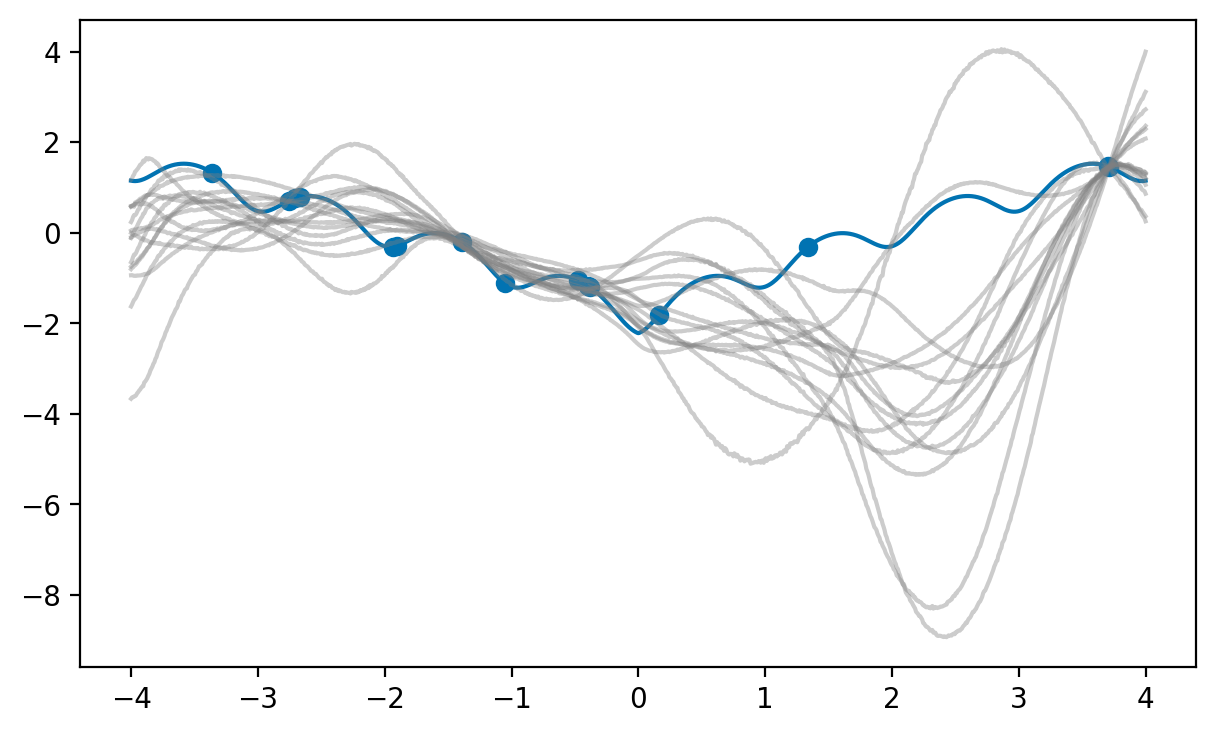

In [29]:
plt.plot(xrange, yvals)
ysamples = join_eval(sample_params, mean_hidden, xrange[:, None])
plt.plot(xrange, ysamples.T, c="gray", alpha=0.4)
plt.scatter(x_samples, y_samples);

# Low-rank last layer

In [30]:
from rebayes_mini.methods import low_rank_last_layer as olli

In [31]:
x_samples = jax.random.uniform(key_data, shape=(10,1), minval=-4, maxval=4)

In [32]:
y_samples = ackley_1d(x_samples)
y_samples = (y_samples - ymean) / ystd

In [33]:
def callback(bel_update, bel_prior, y, x, agent):
    yhat = agent.mean_fn(bel_update.mean_hidden, bel_update.mean_last, x)
    R_half = jnp.linalg.cholesky(jnp.atleast_2d(agent.covariance(yhat)), upper=True)
    # Jacobian for hidden and last layer
    J_hidden = agent.jac_hidden(bel_update.mean_hidden, bel_update.mean_last, x)
    J_last = agent.jac_last(bel_update.mean_hidden, bel_update.mean_last, x)

    # Innovation
    err = y - yhat - J_hidden @ (bel_prior.mean_hidden - bel_update.mean_hidden) - J_last @ (bel_prior.mean_last - bel_update.mean_last)

    return jnp.abs(err)

In [34]:
%%time
model = MLP()
params_init = model.init(key_train, x_samples)

def cov_fn(y): return 0.0
agent = olli.LowRankLastLayer(
    model.apply, cov_fn, rank=50, dynamics_hidden=0.0, dynamics_last=0.0,
)
# agent = olli.LowRankLastLayerIt(
#     model.apply, cov_fn, rank=200, dynamics_hidden=0.0, dynamics_last=1e-5,
#     n_it_hidden=1, n_it_last=1
# )
# bel_init = agent.init_bel(params_init, cov_hidden=1e-3, cov_last=2.0)
bel_init = agent.init_bel(params_init, cov_hidden=1e-3, cov_last=4.0)

cfn = partial(callback, agent=agent)
bel, hist = agent.scan(bel_init, y_samples, x_samples, cfn)
hist = jax.tree.map(np.array, hist)
bel = jax.block_until_ready(bel)

CPU times: user 2.29 s, sys: 75.8 ms, total: 2.36 s
Wall time: 1.64 s


In [35]:
hist.squeeze()

array([0.3455 , 1.08026, 2.67317, 0.2518 , 0.16408, 0.02579, 4.38158, 0.76129, 0.01187, 1.13088], dtype=float32)

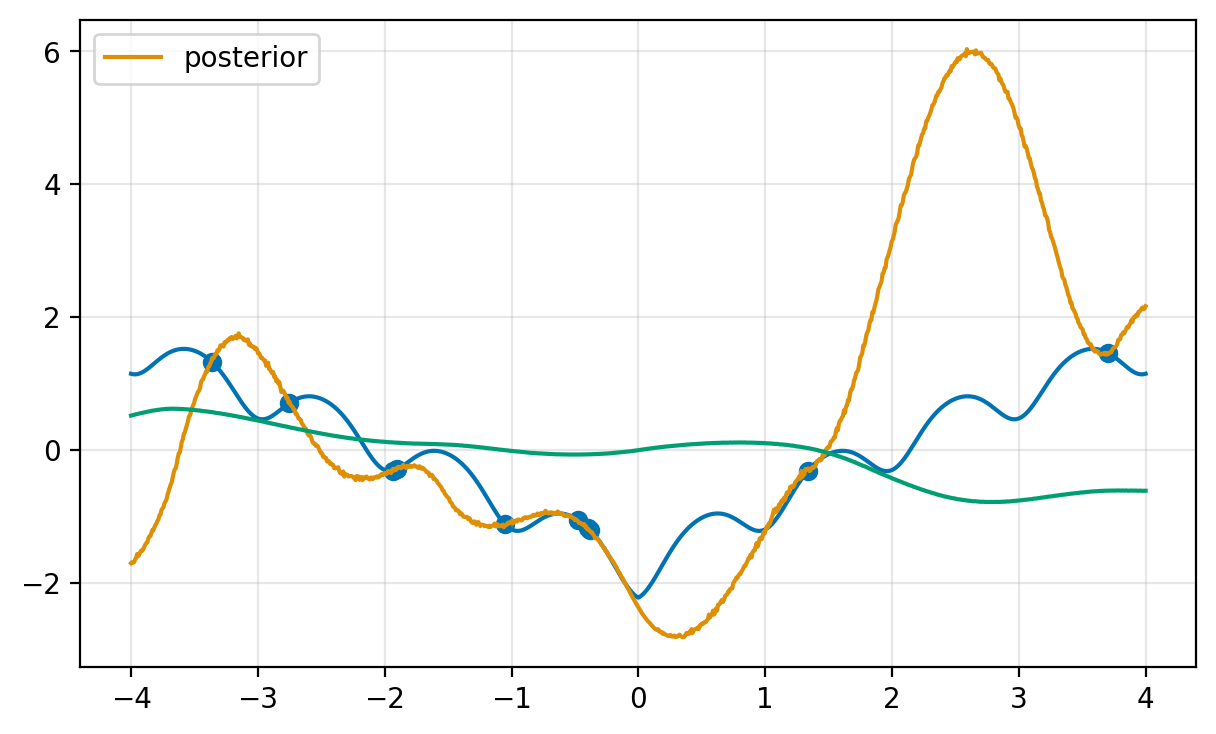

In [36]:
plt.scatter(x_samples, y_samples)

plt.plot(xrange, yvals)
plt.plot(xrange, agent.mean_fn(bel.mean_hidden, bel.mean_last, xrange[:, None]), label="posterior")
plt.plot(xrange, agent.mean_fn(bel_init.mean_hidden, bel_init.mean_last, xrange[:, None]))
plt.legend()
plt.grid(alpha=0.3)

In [37]:
eps = jax.random.normal(key_sample, (30, len(bel.mean_last)))

In [38]:
sample_params = jnp.einsum("ji,sj->si", bel.loading_last, eps) + bel.mean_last

In [39]:
@partial(jax.vmap, in_axes=(0, None, None))
def join_eval(ll_params, hidden_params, x):
    return agent.mean_fn(hidden_params,ll_params, x).squeeze()

In [40]:
ysamples = join_eval(sample_params, bel.mean_hidden, xrange[:, None])

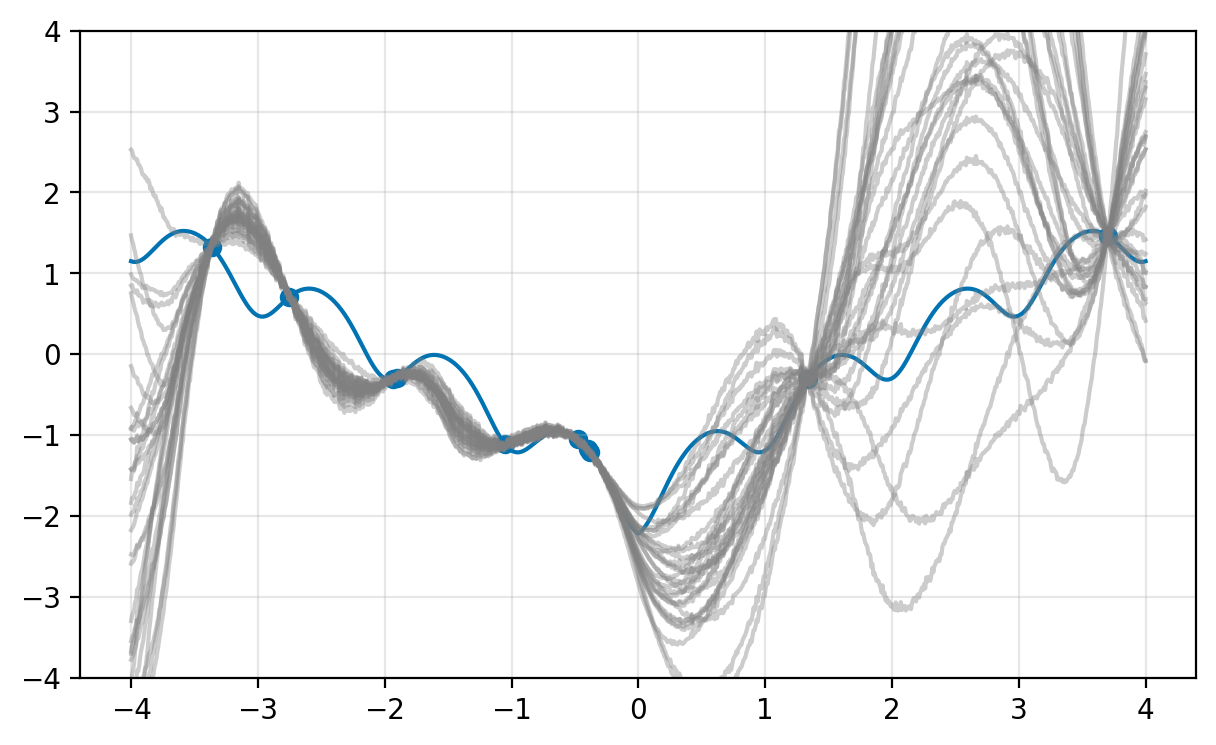

In [41]:
plt.plot(xrange, yvals)

plt.plot(xrange, ysamples.T, c="gray", alpha=0.4)
plt.scatter(x_samples, y_samples)
plt.ylim(-4, 4)
plt.grid(alpha=0.3)

## Function maximisation through Thompson sampling

### Surrogate model

In [42]:
key = jax.random.PRNGKey(314)
key_init_params, key_init_x, key_eval = jax.random.split(key, 3)

In [95]:
surrogate = MLP()
params_init = surrogate.init(key_init_params, x_samples)

def cov_fn(y): return 0.0
agent = olli.LowRankLastLayer(
    surrogate.apply, cov_fn, rank=50, dynamics_hidden=0.0, dynamics_last=0.0,
)

bel_init = agent.init_bel(params_init, cov_hidden=1e-3, cov_last=4.0)

In [96]:
hist_y = []
hist_x = []

### Initial sample and update

In [97]:
key_eval = jax.random.fold_in(key_eval, 1)

In [98]:
x_init = jax.random.uniform(key_init_x, shape=(1,), minval=-4, maxval=4)
y_init = ackley_1d(x_init)
(x_init, y_init)

hist_y.append(y_init.item())
hist_x.append(x_init.item())

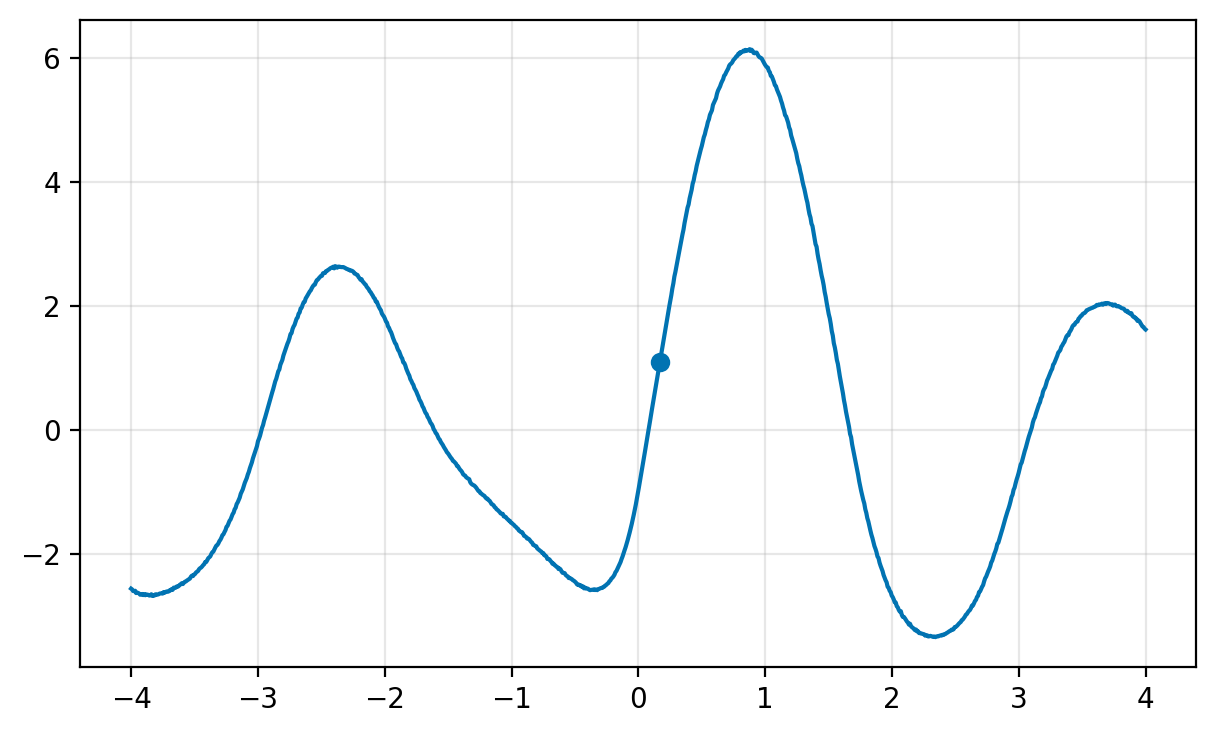

In [99]:
# Update beliefs
bel = agent.update(bel_init, y_init, x_init)

# Sample
ll_params = agent.sample_params_last_layer(key_eval, bel).squeeze()

fn_sampled = agent.mean_fn(bel.mean_hidden, ll_params, xrange[:, None])
plt.scatter(x_init, y_init)
plt.plot(xrange, fn_sampled)
plt.grid(alpha=0.3)

## Second step

In [100]:
key_eval = jax.random.fold_in(key_eval, 2)

In [101]:
x_next = xrange[fn_sampled.argmin()]
y_next = ackley_1d(x_next)

hist_x.append(x_next.item())
hist_y.append(y_next.item())

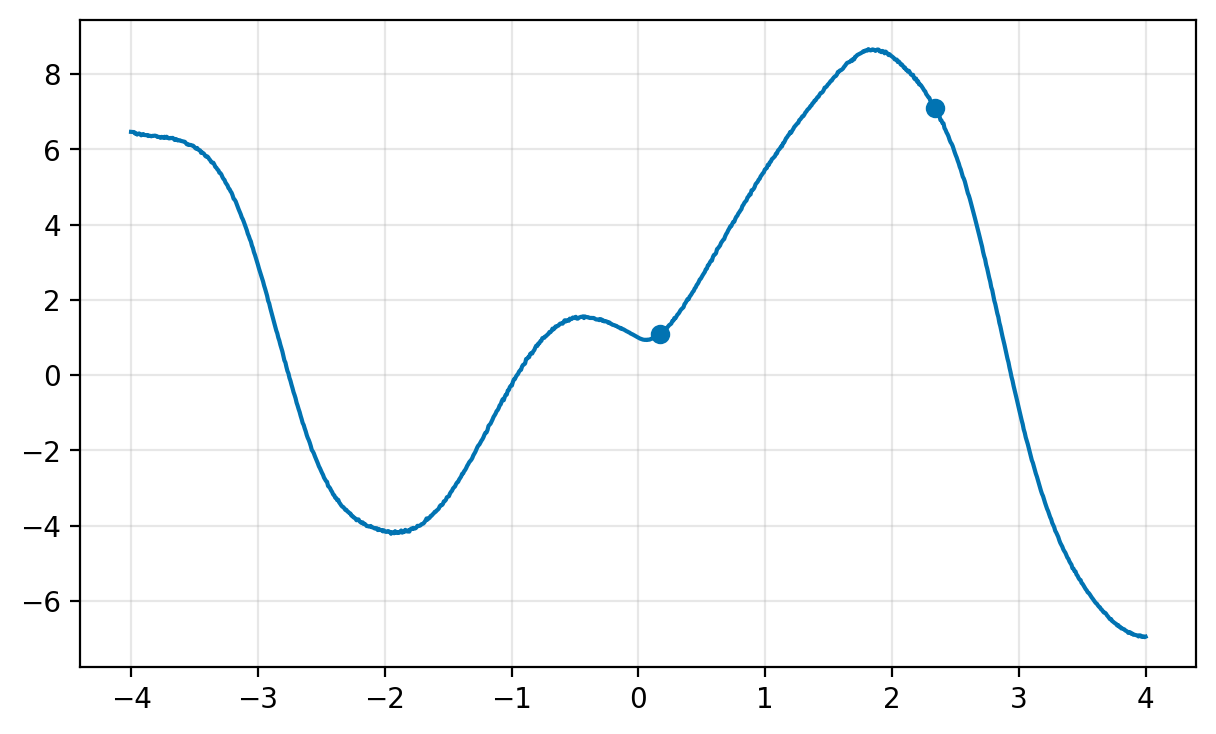

In [102]:
# Update beliefs
bel = agent.update(bel, y_next, jnp.atleast_1d(x_next))

# Sample
ll_params = agent.sample_params_last_layer(key_eval, bel).squeeze()

fn_sampled = agent.mean_fn(bel.mean_hidden, ll_params, xrange[:, None])
plt.scatter(hist_x, hist_y)
plt.plot(xrange, fn_sampled)
plt.grid(alpha=0.3)

## Third step

In [103]:
key_eval = jax.random.fold_in(key_eval, 3)

In [104]:
x_next = xrange[fn_sampled.argmin()]
y_next = ackley_1d(x_next)

hist_x.append(x_next.item())
hist_y.append(y_next.item())

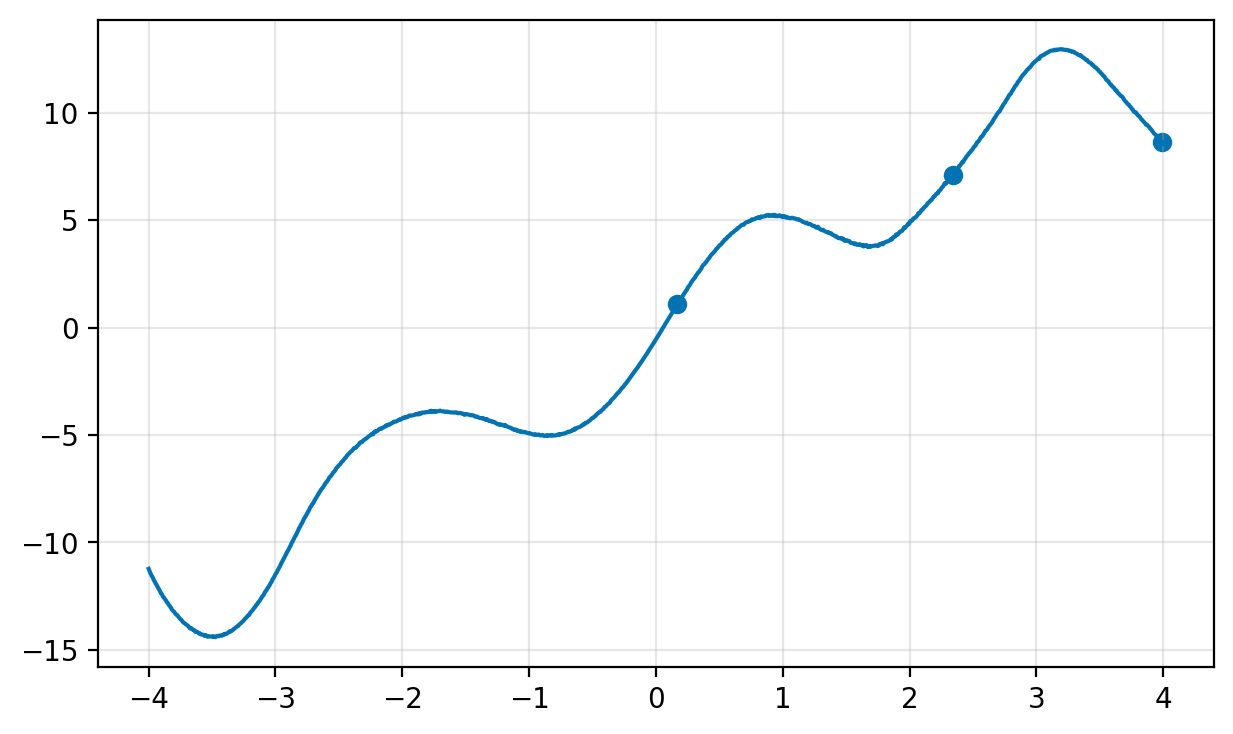

In [105]:
# Update beliefs
bel = agent.update(bel, y_next, jnp.atleast_1d(x_next))

# Sample
ll_params = agent.sample_params_last_layer(key_eval, bel).squeeze()

fn_sampled = agent.mean_fn(bel.mean_hidden, ll_params, xrange[:, None])
plt.scatter(hist_x, hist_y)
plt.plot(xrange, fn_sampled)
plt.grid(alpha=0.3)

## Eval

### Initial sample and update

In [85]:
key = jax.random.PRNGKey(31)
key_init_params, key_init_x, key_eval = jax.random.split(key, 3)

In [86]:
surrogate = MLP()
params_init = surrogate.init(key_init_params, x_samples)

def cov_fn(y): return 0.0
agent = olli.LowRankLastLayer(
    surrogate.apply, cov_fn, rank=50, dynamics_hidden=0.0, dynamics_last=0.0,
)

bel_init = agent.init_bel(
    params_init,
    cov_hidden=1e-3, # parameters do not vary much from their initial parameters
    cov_last=5.0 # uncertainty in target
)

In [87]:
def eval_update(state, t, key):
    bel, x_next, y_next = state
    x_next = jnp.atleast_1d(x_next)
    # Update beliefs
    key_eval = jax.random.fold_in(key, t)
    bel = agent.update(bel, y_next, x_next)
    
    ll_params = agent.sample_params_last_layer(key_eval, bel).squeeze()
    fn_sampled = agent.mean_fn(bel.mean_hidden, ll_params, xrange[:, None])

    # Take next point
    x_next = xrange[fn_sampled.argmin()]
    y_next = ackley_1d(x_next).squeeze()

    out = {
        "x": x_next,
        "y": y_next,
        "fn": fn_sampled.squeeze()
    }

    state_next = (bel, x_next, y_next)
    return state_next, out

In [88]:
x_next = jax.random.uniform(key_init_x, minval=-4, maxval=4)
y_next = ackley_1d(x_next)

In [89]:
steps = jnp.arange(15)
state_init = (bel, x_next, y_next)
bel_final, hist = jax.lax.scan(partial(eval_update, key=key_eval), state_init, steps)

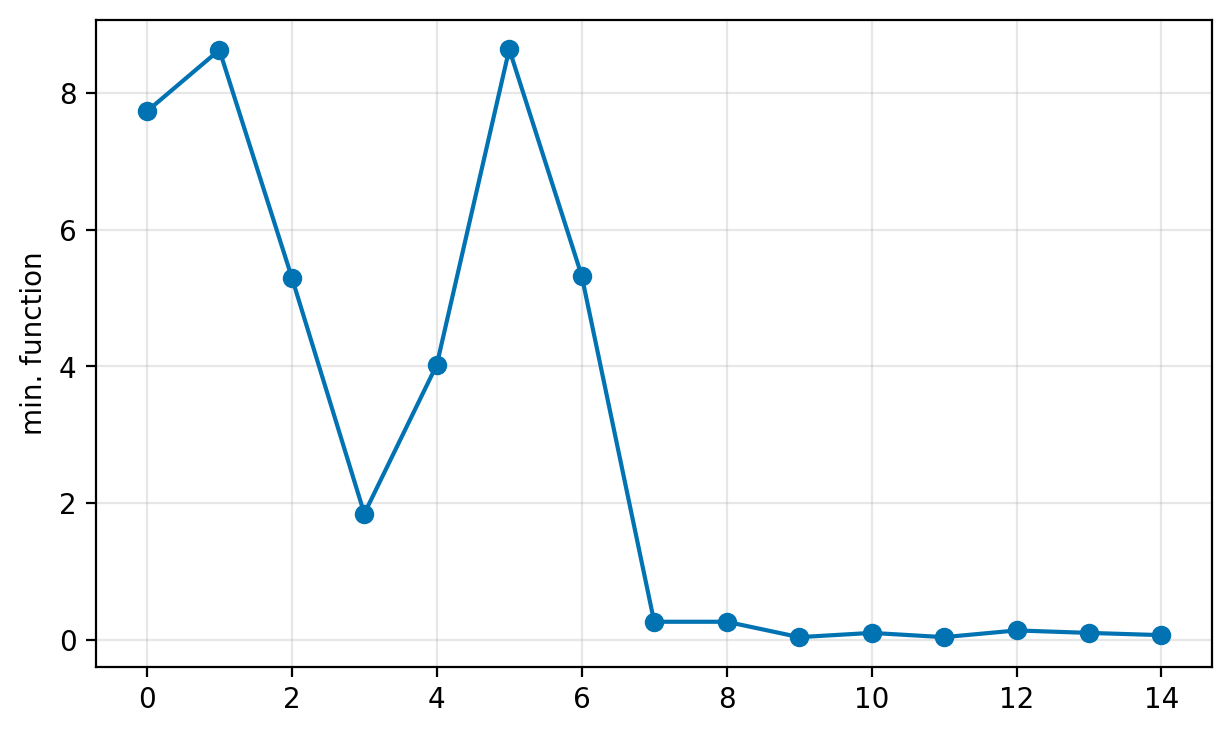

In [90]:
plt.plot(hist["y"], marker="o")
plt.ylabel("min. function")
# plt.yscale("log")
plt.grid(alpha=0.3)

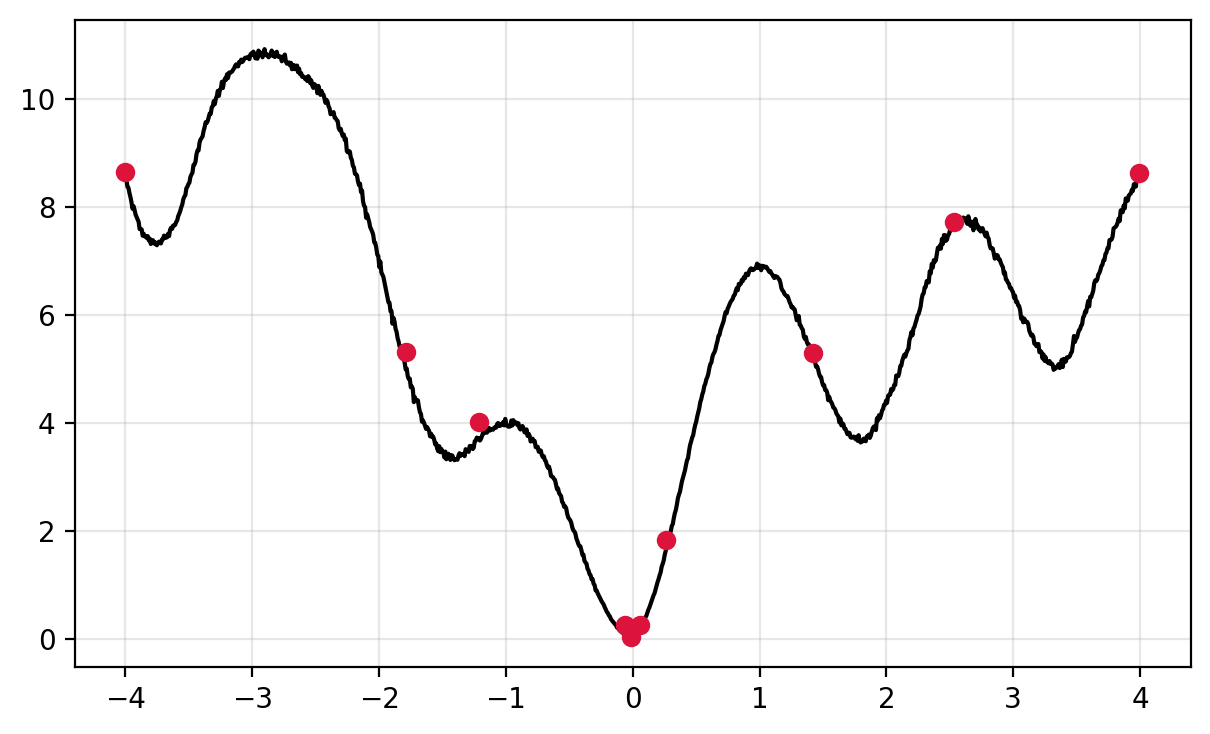

In [91]:
n_obs = 10
plt.plot(xrange, hist["fn"][n_obs], c="black")
plt.scatter(hist["x"][:n_obs], hist["y"][:n_obs], c="crimson", zorder=2)
plt.grid(alpha=0.3)

## Steps

In [ ]:
steps = np.arange(1, 15, 3)

n_rows = len(steps)
fig, axs = plt.subplots(n_rows, 1, sharex=True, sharey=True, figsize=(6.2 * 1.2, 4.8 * 1.8))
for n_obs, ax in zip(steps, axs):
    ax.plot(xrange, hist["fn"][n_obs], c="black", linewidth=2, label="sampled function")
    ax.plot(xrange, ackley_1d(xrange), linestyle="--", label="ground truth")
    ax.scatter(hist["x"][:n_obs], hist["y"][:n_obs], c="crimson", zorder=2)
    ax.grid(alpha=0.3)
    ax.set_ylabel(f"Step {n_obs:02}")
    ax.set_ylim(-1.0, 11)
plt.suptitle("L3R-BNN Bayesian optimisation using Thompson sampling", y=0.92)
ax.legend(loc="lower left");